In [123]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.collections import LineCollection
import time

Define SCP functions

In [147]:
# linearize obstacle constraint
def linearize_nfz_cnst(r, r_ref, r_nfz):
    nfz_rad = r_nfz[2] + 0.01
    
    A = np.array([[1/nfz_rad ** 2, 0], [0, 1/nfz_rad ** 2]])

    diff_ref = r_ref - r_nfz[:2]
    return (1 - cp.quad_form(diff_ref, A)) - diff_ref.T @ (A + A.T) @ (r - r_ref)

# point to point obstacle constraint
def cont_nfz_cnst(r_i, r_j, r_ref_i, r_ref_j, r_nfz, T = 10):

    dr = (r_j - r_i) / T
    dr_ref = (r_ref_j - r_ref_i) / T

    G = 0

    for t in range(1, T - 1):
        r = r_i + t * dr
        r_ref = r_ref_i + t * dr_ref

        G += cp.pos(linearize_nfz_cnst(r, r_ref, r_nfz)) ** 2
    return G


# initialize optimization
def init_opt(r0, r_ref, r_nfz, ptr, l_min):
    r = cp.Variable(np.shape(r0))

    inequality_constraints = []
    equality_constraints = []

    for i in range(r.shape[0] - 1):
        # add obstacle constraints
        for j in range(r_nfz.shape[0]):
            inequality_constraints.append(cont_nfz_cnst(r[i], r[i+1], r_ref[i], r_ref[i+1], r_nfz[j]) <= 0.000001)

            if i > 0:
                inequality_constraints.append(linearize_nfz_cnst(r[i], r_ref[i], r_nfz[j]) <= -0.2)

    # add endpoint constraints
    equality_constraints.append(r[0] == r0[0])
    equality_constraints.append(r[-1] == r0[-1])
    
    all_constraints = inequality_constraints + equality_constraints

    total_cost = 0
    for i in range(r.shape[0]-1):
        total_cost += cp.norm(r[i+1]-r[i])

    if ptr:
        for i in range(r.shape[0]):
            total_cost += 1.1 * cp.norm(r[i]-r_ref[i])

    prob = cp.Problem(cp.Minimize(total_cost), all_constraints)
    return prob

# "main" function to optimize problem in loop
def find_optimal_formation(r0, nfzs, ptr = False, l_min = 50, max_iwoi = 5, tolerance = 0.01):
    r_ref = r0
    iter = 0

    optimal_cost = np.inf
    optimal_formation = None

    formation_hist = []
    formation_hist.append(r0)

    iwoi = 0 #iterations without improvement

    start_opt = time.time()

    while iwoi < max_iwoi:
        opt_prob = init_opt(r0, r_ref, nfzs, ptr, l_min)
        opt_prob.solve(solver=cp.ECOS)

        print(f"Optimization status: {opt_prob.status}")

        if opt_prob.value + tolerance < optimal_cost:
            iwoi = 0
            optimal_cost = opt_prob.value
            optimal_formation = opt_prob.variables()[0].value
            r_ref = optimal_formation
            formation_hist.append(optimal_formation)
        else:
            iwoi += 1
        
        print(f"Iteration {iter+1} complete. Value: {opt_prob.value}, iwoi: {iwoi}")
        iter += 1
    
    end_opt = time.time()
    
    if opt_prob.status == "optimal":
        print(f"Optimization complete. Time: {end_opt - start_opt}")
        
    return optimal_cost, optimal_formation, formation_hist

Function to plot solutions

In [125]:
def plot_soln(r0, form, nfzs, hist):
    solnfigure, solnaxes = plt.subplots()

    # plot initial guess
    plt.plot(r0[:,0],r0[:,1], '--o', color = 'black', alpha = 1, label = 'Initial Guess', linewidth = 1.5)

    if form is not None:
        # plot subproblem solutions
        subproblem_solns = LineCollection(hist[1:-1], linestyles = '--', color = 'blue', alpha = 0.4, label = 'Subproblem Solutions', linewidth = 1.5)
        solnaxes.add_collection(subproblem_solns)
        for h in hist[1:-1]:
            plt.scatter(h[:, 0], h[:, 1], color='blue', alpha=0.2)

        # plot converged solution
        plt.plot(form[:,0], form[:,1], '-o', color = 'green', label = 'Converged Solution', linewidth = 2.7)

    # plot no-fly zones
    for n in nfzs:
        draw_nfz = plt.Circle((n[0], n[1]), n[2], fill = True, color = 'red', alpha = 0.3)
        solnaxes.add_artist(draw_nfz)

    solnaxes.set_xlim([0, 110])
    solnaxes.set_ylim([0, 110])
    solnaxes.legend(loc = 'best', fontsize = 8)

    plt.show()
    return

Generate Figure 2 in report ("good" solution)

Optimization status: optimal_inaccurate
Iteration 1 complete. Value: 3045.7716881031647, iwoi: 0
Optimization status: optimal
Iteration 2 complete. Value: 1544.7851014173493, iwoi: 0
Optimization status: optimal
Iteration 3 complete. Value: 821.8188338572189, iwoi: 0
Optimization status: optimal
Iteration 4 complete. Value: 444.09993538015726, iwoi: 0
Optimization status: optimal
Iteration 5 complete. Value: 263.429751669899, iwoi: 0
Optimization status: optimal
Iteration 6 complete. Value: 185.8120058652805, iwoi: 0
Optimization status: optimal
Iteration 7 complete. Value: 157.36334876300108, iwoi: 0
Optimization status: optimal
Iteration 8 complete. Value: 144.80270141495163, iwoi: 0
Optimization status: optimal
Iteration 9 complete. Value: 140.74215957422703, iwoi: 0
Optimization status: optimal
Iteration 10 complete. Value: 140.5099565722582, iwoi: 0
Optimization status: optimal
Iteration 11 complete. Value: 140.50693877929737, iwoi: 1
Optimization status: optimal
Iteration 12 comp

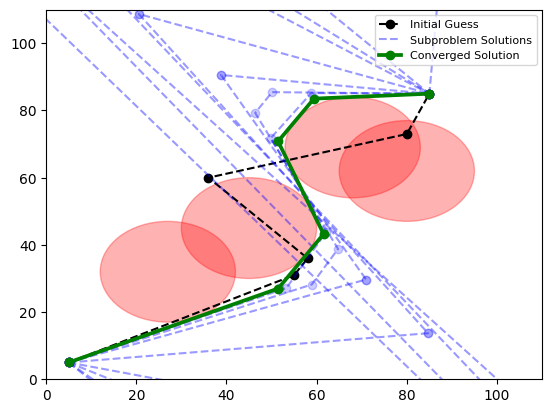

In [144]:
r0 = np.array([[ 5,  5],
               [55, 31],
               [58, 36],
               [36, 60],
               [80, 73],
               [85, 85]])

radius = 15
nfzs = np.array([[27,32,radius],[45,45,radius],[68,69,radius], [80,62,radius]])

cost, form, hist = find_optimal_formation(r0,nfzs)
plot_soln(r0, form, nfzs, hist)

Generate figure 3 in report

Optimization status: infeasible
Iteration 1 complete. Value: inf, iwoi: 1
Optimization status: infeasible
Iteration 2 complete. Value: inf, iwoi: 2
Optimization status: infeasible
Iteration 3 complete. Value: inf, iwoi: 3
Optimization status: infeasible
Iteration 4 complete. Value: inf, iwoi: 4
Optimization status: infeasible
Iteration 5 complete. Value: inf, iwoi: 5


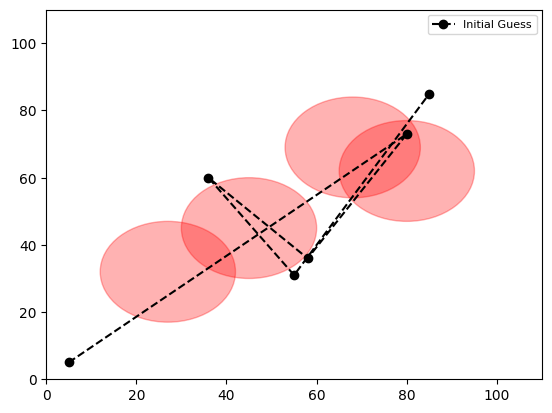

In [132]:
r0 = np.array([[ 5,  5],
               [80, 73],
               [58, 36],
               [36, 60],
               [55, 31],
               [85, 85]])

radius = 15
nfzs = np.array([[27,32,radius],[45,45,radius],[68,69,radius], [80,62,radius]])

cost, form, hist = find_optimal_formation(r0,nfzs)
plot_soln(r0, form, nfzs, hist)

Generate figure 4

c:\Users\jskzhou\AppData\Local\anaconda3\envs\py-cvx\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimization status: optimal_inaccurate
Iteration 1 complete. Value: 3540.7505391948844, iwoi: 0
Optimization status: optimal_inaccurate
Iteration 2 complete. Value: 1801.727115375783, iwoi: 0
Optimization status: optimal_inaccurate
Iteration 3 complete. Value: 950.5235557990472, iwoi: 0
Optimization status: optimal
Iteration 4 complete. Value: 526.0518164164506, iwoi: 0
Optimization status: optimal
Iteration 5 complete. Value: 318.7740772979369, iwoi: 0
Optimization status: optimal
Iteration 6 complete. Value: 221.57279366814998, iwoi: 0
Optimization status: optimal
Iteration 7 complete. Value: 178.0188759791843, iwoi: 0
Optimization status: optimal
Iteration 8 complete. Value: 160.13946400475368, iwoi: 0
Optimization status: optimal
Iteration 9 complete. Value: 153.55710284428037, iwoi: 0
Optimization status: optimal
Iteration 10 complete. Value: 152.2585679284477, iwoi: 0
Optimization status: optimal
Iteration 11 complete. Value: 152.20428932164845, iwoi: 0
Optimization status: opti

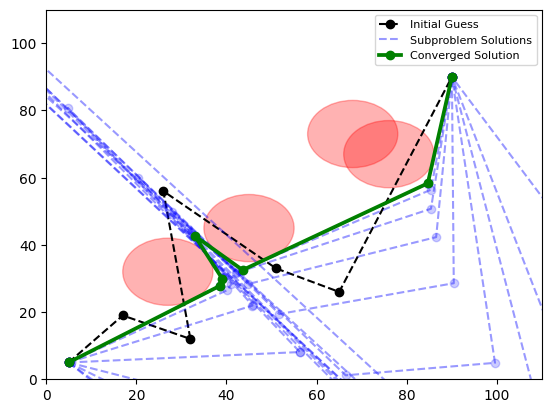

In [151]:
r0 = np.array([[ 5,  5],
               [17, 19],
               [32, 12],
               [26, 56],
               [51, 33],
               [65, 26],
               [90, 90]])

radius = 10
nfzs = np.array([[27,32,radius],[45,45,radius],[68,73,radius], [76,67,radius]])

cost, form, hist = find_optimal_formation(r0,nfzs)
plot_soln(r0, form, nfzs, hist)

Generate Random results (figure 5 and 6)

Optimization status: optimal
Iteration 1 complete. Value: 225.91773903306122, iwoi: 0
Optimization status: optimal
Iteration 2 complete. Value: 173.59236423137367, iwoi: 0
Optimization status: optimal
Iteration 3 complete. Value: 173.59207646914854, iwoi: 1
Optimization status: optimal
Iteration 4 complete. Value: 173.59207646914854, iwoi: 2
Optimization status: optimal
Iteration 5 complete. Value: 173.59207646914854, iwoi: 3
Optimization status: optimal
Iteration 6 complete. Value: 173.59207646914854, iwoi: 4
Optimization status: optimal
Iteration 7 complete. Value: 173.59207646914854, iwoi: 5
Optimization complete. Time: 4.497506380081177
173.59207636581326
[[ 5.          5.        ]
 [47.98184566  3.75000947]
 [47.98184593  3.75000937]
 [69.44999692 25.15154476]
 [59.56028872 50.07290243]
 [48.31860251 72.76222336]
 [58.08051257 84.56962097]
 [61.156758   86.81029586]
 [90.         90.        ]]


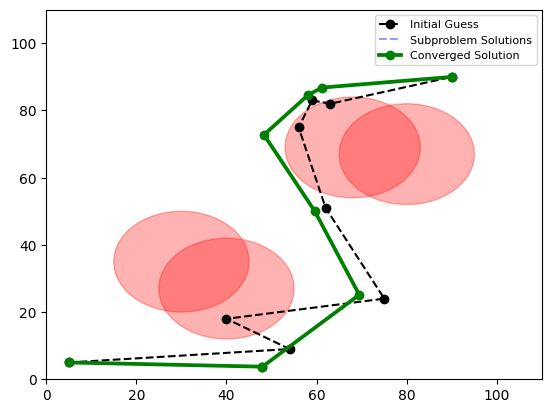

In [152]:
# initial nodes
r0 = np.array([[5,5]])
dest = np.array([90,90])

for i in range(7):
    point = np.array([random.randrange(6,84), random.randrange(6,84)])
    r0 = np.insert(r0, 1, point, axis = 0)

r0 = sorted(r0, key = lambda x:np.linalg.norm(x - dest), reverse=True)
r0 = np.vstack([r0, dest])

# obstacles
radius = 15

# for i in range (0, n_nfz):
#     nfzs[i, 0] = random.randrange(100-2*radius)
#     nfzs[i, 1] = random.randrange(100-2*radius)
#     nfzs[i, 2] = random.randrange(radius)

nfzs = np.array([[40,27,radius],[30,35,radius],[68,69,radius], [80,67,radius]])

ptr = True

cost, form, hist = find_optimal_formation(r0,nfzs,ptr)

if ptr:
    cost = 0
    for i in range(len(form) - 1):
        cost += np.linalg.norm(form[i] - form[i+1])

print(cost)
print(form)
plot_soln(r0, form, nfzs, hist)

Complete randomized initial node and obstacle generation (LOTS of infeasible problems)

Optimization status: optimal
Iteration 1 complete. Value: 1116.7623244729702, iwoi: 0
Optimization status: optimal
Iteration 2 complete. Value: 616.9041187647729, iwoi: 0
Optimization status: optimal
Iteration 3 complete. Value: 436.3157283332102, iwoi: 0
Optimization status: optimal
Iteration 4 complete. Value: 386.69600841144035, iwoi: 0
Optimization status: optimal
Iteration 5 complete. Value: 381.07775193465255, iwoi: 0
Optimization status: optimal
Iteration 6 complete. Value: 380.9883609387368, iwoi: 0
Optimization status: optimal
Iteration 7 complete. Value: 380.98664013133435, iwoi: 1
Optimization status: optimal
Iteration 8 complete. Value: 380.98664013133435, iwoi: 2
Optimization status: optimal
Iteration 9 complete. Value: 380.98664013133435, iwoi: 3
Optimization status: optimal
Iteration 10 complete. Value: 380.98664013133435, iwoi: 4
Optimization status: optimal
Iteration 11 complete. Value: 380.98664013133435, iwoi: 5
Optimization complete. Time: 5.236270189285278
380.9867

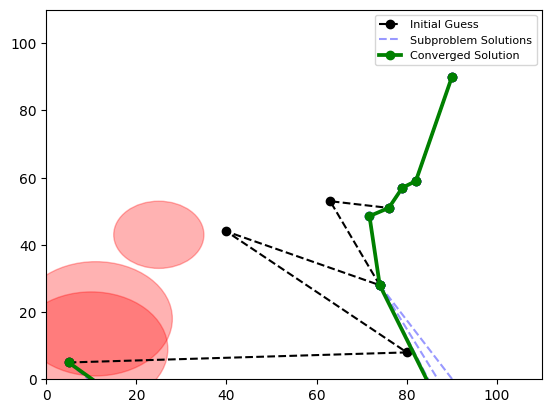

In [170]:
# initial nodes
r0 = np.array([[5,5]])
dest = np.array([90,90])

for i in range(7):
    point = np.array([random.randrange(6,84), random.randrange(6,84)])
    r0 = np.insert(r0, 1, point, axis = 0)

r0 = sorted(r0, key = lambda x:np.linalg.norm(x - dest), reverse=True)
r0 = np.vstack([r0, dest])

# obstacles
radius = 20
n_nfz = 3
nfzs = np.zeros((n_nfz, 3))

for i in range (0, n_nfz):
    nfzs[i, 0] = random.randrange(100-2*radius)
    nfzs[i, 1] = random.randrange(100-2*radius)
    nfzs[i, 2] = random.randrange(10, radius)

ptr = True

cost, form, hist = find_optimal_formation(r0,nfzs,ptr)

if ptr:
    cost = 0
    for i in range(len(form) - 1):
        cost += np.linalg.norm(form[i] - form[i+1])

print(cost)
print(form)
plot_soln(r0, form, nfzs, hist)